In [51]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import statsmodels as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_pacf
import pandas as pd
import warnings
import plotly.express as px
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from sktime.forecasting.naive import NaiveForecaster
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from pmdarima import auto_arima
import statsmodels.formula.api as smf
from tssb.utils import load_time_series_segmentation_datasets, relative_change_point_distance
from sktime.annotation.clasp import ClaSPSegmentation
import matrixprofile as mp
from matrixprofile.visualize import plot_discords_mp
from tssb.utils import visualize_time_series
import librosa, librosa.display
from darts import TimeSeries
from darts.models.forecasting.exponential_smoothing import ExponentialSmoothing
# from darts.models.forecasting.rnn_model import RNNModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

import matrixprofile_ts as mpts
from matrixprofile_ts.matrixProfile import stomp
from matrixprofile_ts.fluss import fluss
from matrixprofile_ts.motifs import motifs

warnings.filterwarnings('ignore')

## Section 3

### Section 3.1

- Simulate a white noise for 200 observations and plot it.

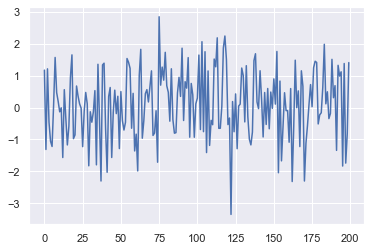

In [2]:
white_noise = np.random.normal(0, 1, 200)

plt.plot(white_noise)
plt.show()

- Create a white noise with mean = 4, sd = 2. Then use the arima function to estimate the parameters.

In [3]:
white_noise = np.random.normal(4, 2, 200)
ARIMA(white_noise, order=(0, 0, 0)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  200
Model:                          ARIMA   Log Likelihood                -408.302
Date:                Mon, 12 Dec 2022   AIC                            820.604
Time:                        15:30:09   BIC                            827.201
Sample:                             0   HQIC                           823.274
                                - 200                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9100      0.133     29.324      0.000       3.649       4.171
sigma2         3.4735      0.312     11.120      0.000       2.861       4.086
===================================================================================
Ljung-Box (L1) (Q):                   0.65   Jarque-Bera (JB):                 4.31
Prob(Q):                              0.42   Prob(JB):                         0.12
Heteroskedasticity (H):               0.85   Skew:                            -0.24
Prob(H) (two-sided):                  0.50   Kurtosis:                         3.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Describe what a random walk is and what stationarity means for a time series.

A random walk can be defined as a series of discrete steps an object takes in some direction. In a random walk, the future position is entirely independent of the current position of an object. Stationarity means that the statistical properties of a time series (or rather the process generating it) do not change over time.

- Create a random walk series, plot it, calculate the first difference series and plot it.

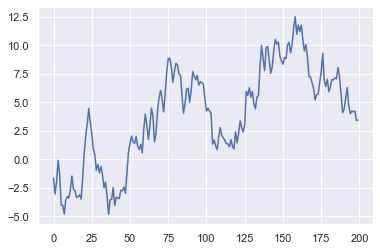

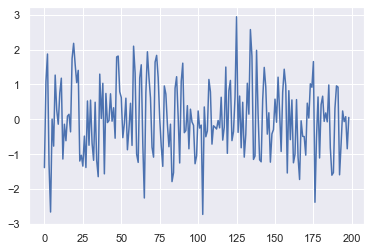

In [4]:
random_walk = np.random.normal(0, 1, 200)
random_walk = np.cumsum(random_walk)

plt.plot(random_walk)
plt.show()

random_walk_diff = np.diff(random_walk)
plt.plot(random_walk_diff)
plt.show()

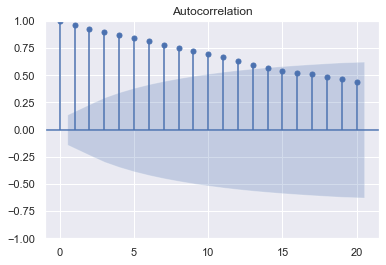

In [5]:
plot_acf(random_walk, lags=20).show()

- Generate white noise drift data, convert it to a random walk and plot it.

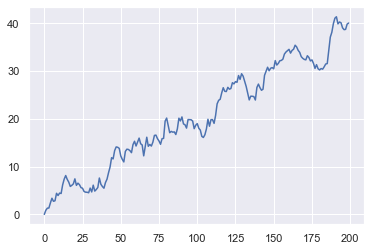

In [6]:
noise_drift = np.random.normal(0, 1, 200)
noise_drift = np.cumsum(noise_drift) + (np.arange(200)/5)

plt.plot(noise_drift)
plt.show()

- Plot the ACF on the white noise.

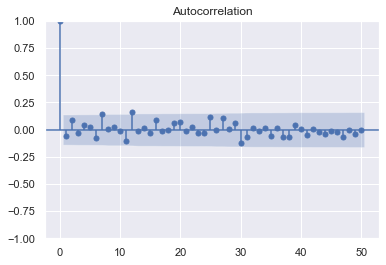

In [7]:
plot_acf(white_noise, lags=50)
plt.show()

- What’s the characteristic of a white noise ACF ?

The white noise ACF is 0 for all lags and not statistically significant.

- Perform a Ljung-Box Test.

In [8]:
acorr_ljungbox(white_noise, lags=10)

lb_stat  lb_pvalue
1   0.651067   0.419731
2   2.309407   0.315151
3   2.461264   0.482332
4   2.876407   0.578717
5   2.976620   0.703591
6   4.114544   0.661179
7   8.252823   0.310829
8   8.254070   0.409054
9   8.341349   0.500146
10  8.390894   0.590712

### Section 3.2

- Use the arima.sim function (or Python equivalent) to generate time series based on the autoregressive model, with slopes comprised between -1 and 1.

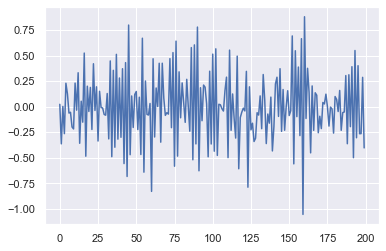

In [9]:
AR_object = ArmaProcess(ar = [4, 3])
simulated_data = AR_object.generate_sample(nsample=200)

plt.plot(simulated_data)
plt.show()

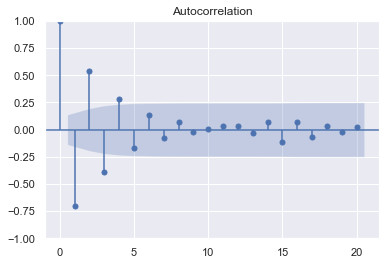

In [10]:
plot_acf(simulated_data, lags=20).show()

- What do you observe ?

The ACF is not 0 for all lags and is statistically significant.

- Do the same with the moving average model.

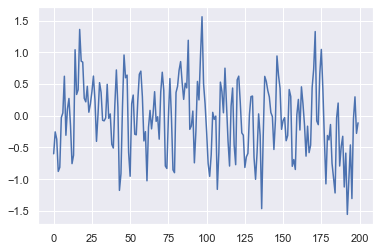

In [11]:
MA_object = ArmaProcess(ma = [0.5, 0.25])
simulated_data_2 = MA_object.generate_sample(nsample=200)

plt.plot(simulated_data_2)
plt.show()

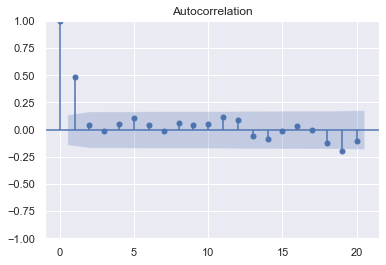

In [12]:
plot_acf(simulated_data_2, lags=20).show()

- What do you observe ?

The ACF is not 0 for all lags and is statistically significant.

- Contrast AR(1) and AR(2) models.

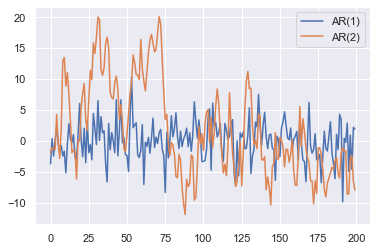

In [13]:
AR_object = ArmaProcess(ar = [0.3])
simulated_data = AR_object.generate_sample(nsample=200)
plt.plot(simulated_data)

AR_object = ArmaProcess(ar = [0.3, -0.25])
simulated_data_2 = AR_object.generate_sample(nsample=200)
plt.plot(simulated_data_2)

plt.legend(['AR(1)','AR(2)'])
plt.show()

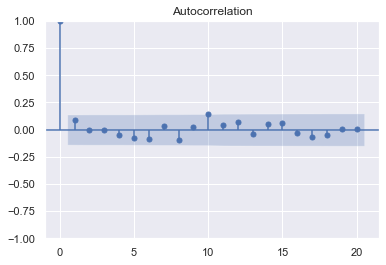

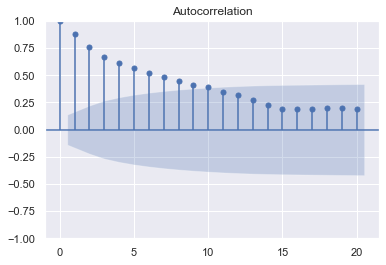

In [14]:
plot_acf(simulated_data, lags=20).show()
plot_acf(simulated_data_2, lags=20).show()

- How do they differ ?


The AR(2) model is more dependent on the parameters than the AR(1) model.

- What is the difference between an Autocorrelation Function and a Partialautocorrelation Function ?

The autocorrelation function (ACF) is the correlation between the time series and a lagged version of itself. The partial autocorrelation function (PACF) is the correlation between the time series and a lagged version of itself that has been regressed out of the time series.

- Plot the ACF and the PACF of an AR, a MA, and ARMA models.

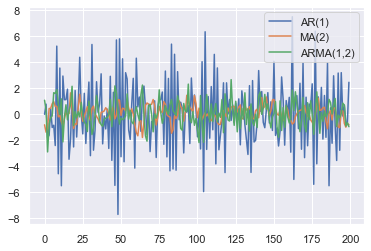

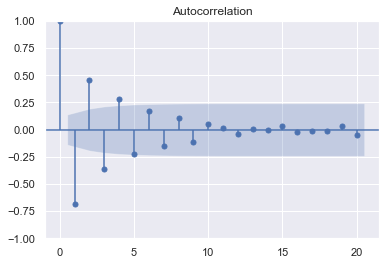

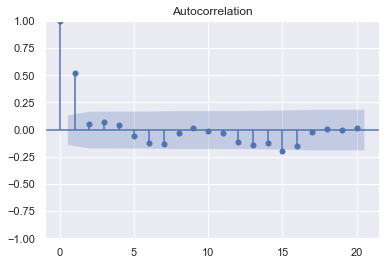

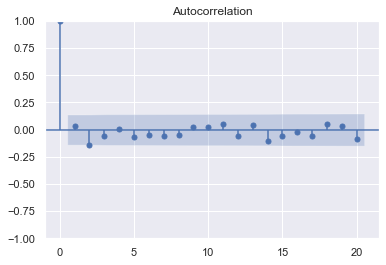

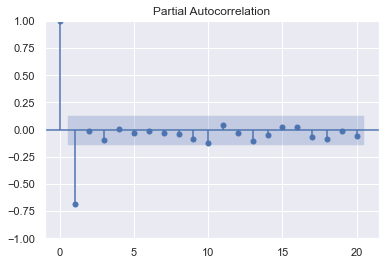

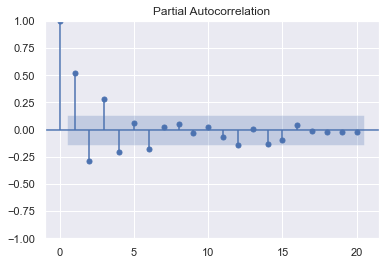

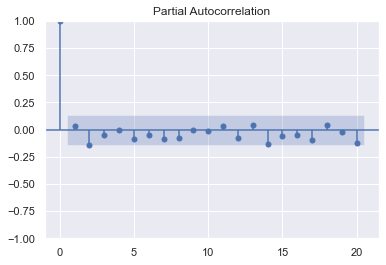

In [15]:
AR_object = ArmaProcess(ar = [0.5, 0.4])
simulated_data = AR_object.generate_sample(nsample=200)
plt.plot(simulated_data)

MA_object = ArmaProcess(ma = [0.5, 0.4])
simulated_data_2 = MA_object.generate_sample(nsample=200)
plt.plot(simulated_data_2)

ARMA_object = ArmaProcess(ar = [0.5, 0.4], ma = [0.5, 0.4])
simulated_data_3 = ARMA_object.generate_sample(nsample=200)
plt.plot(simulated_data_3)

plt.legend(['AR(1)','MA(2)','ARMA(1,2)'])
plt.show()

plot_acf(simulated_data, lags=20).show()
plot_acf(simulated_data_2, lags=20).show()
plot_acf(simulated_data_3, lags=20).show()

plot_pacf(simulated_data, lags=20, method='ywm').show()
plot_pacf(simulated_data_2, lags=20, method='ywm').show()
plot_pacf(simulated_data_3, lags=20, method='ywm').show()

- What are the main differences ?



- Write the equation of an ARMA model.

$$X_t = \mu + \epsilon_t + \varphi_1 \epsilon_{t-1} + \varphi_2 \epsilon_{t-2} + \dots + \varphi_p \epsilon_{t-p} + \theta_1 X_{t-1} + \theta_2 X_{t-2} + \dots + \theta_q X_{t-q}$$

- What are the main differences between AIC and BIC criteria, conceptually speaking ?

AIC and BIC are criteria used to choose the best model. AIC is a measure of the relative quality of a statistical model for a given set of data. BIC is a criterion for model selection among a finite set of models, where the model with the lowest BIC is preferred. BIC is a variant of AIC that includes a penalty term for the number of parameters in a model.

## Section 4

In [16]:
item_cat = pd.read_csv('source/item_categories.csv')
items = pd.read_csv('source/items.csv')
sales_train = pd.read_csv('source/sales_train.csv', parse_dates=['date'], infer_datetime_format=True)
sample_sub = pd.read_csv('source/sample_submission.csv')
shops = pd.read_csv('source/shops.csv')
test = pd.read_csv('source/test.csv')

In [17]:
sales_by_day = sales_train[['date','item_price','item_cnt_day']].groupby('date').sum()
sales_by_day.reset_index(inplace=True)

In [18]:
fig = px.line(sales_by_day, x="date", y="item_cnt_day")
fig.show()

- Choose from the sales list the item, whose id is 20949.

In [19]:
sales_20949 = sales_train[sales_train['item_id'] == 20949]
sales_20949 = sales_20949[['date','item_price','item_cnt_day']].groupby('date').sum()

- Create a time series with lag 1.

In [20]:
sales_20949['lag_1'] = sales_20949['item_cnt_day'].shift(1)

- Use the corr function and plot the acf with lag 1.

In [21]:
sales_20949.corr()

item_price  item_cnt_day     lag_1
item_price      1.000000      0.627163  0.388849
item_cnt_day    0.627163      1.000000  0.526022
lag_1           0.388849      0.526022  1.000000

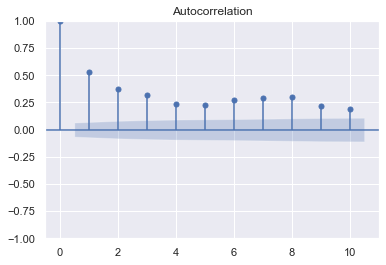

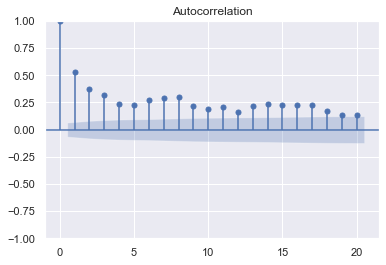

In [22]:
plot_acf(sales_20949['item_cnt_day'], lags=10).show()
plot_acf(sales_20949['item_cnt_day'], lags=20).show()

- Fit and plot an auto-regressive model to the time series.

                               SARIMAX Results                                
Dep. Variable:           item_cnt_day   No. Observations:                  921
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -5641.454
Date:                Mon, 12 Dec 2022   AIC                          11288.907
Time:                        15:30:14   BIC                          11303.384
Sample:                             0   HQIC                         11294.431
                                - 921                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        203.7372     10.325     19.732      0.000     183.500     223.974
ar.L1          0.5258      0.015     35.977      0.000       0.497       0.554
sigma2      1.225e+04    257.109     47.635      0.0

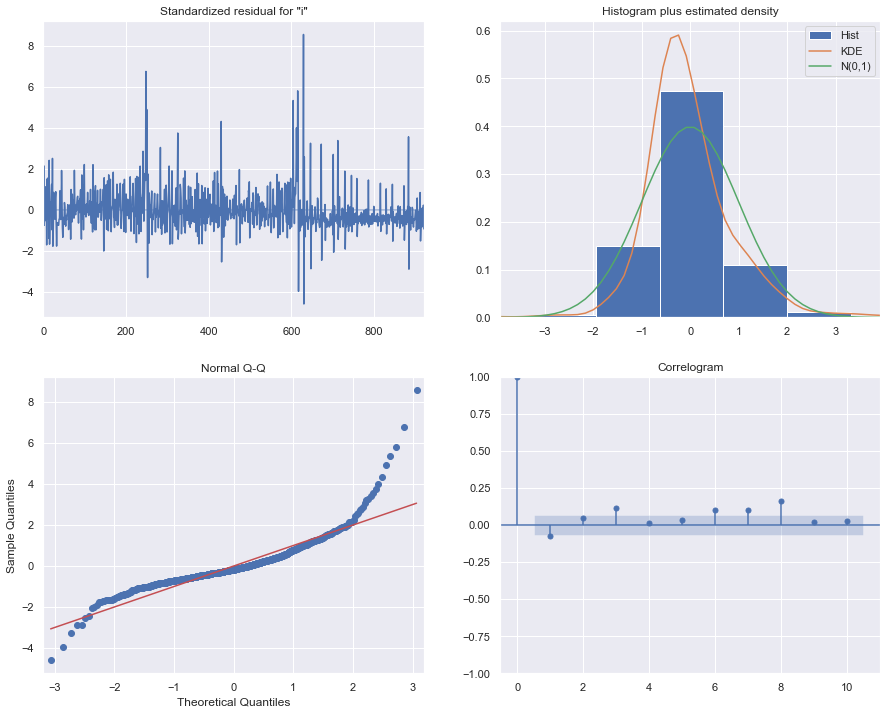

In [23]:
model = ARIMA(sales_20949['item_cnt_day'], order=(1,0,0))
model_fit = model.fit()
print(model_fit.summary())

model_fit.plot_diagnostics(figsize=(15,12))
plt.show()

- What are the intercept and the innovation variance (sigma2) estimate ? What do these parameters mean ?

The intercept is 5.9873 and the innovation variance is 121.3464. The intercept is the mean of the time series and the innovation variance is the variance of the residuals.

- Predict the sales for a month after the end of the training dataset.

<AxesSubplot:>

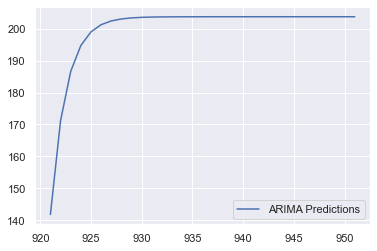

In [24]:
predictions = model_fit.predict(start=len(sales_20949), end=len(sales_20949)+30, typ='levels').rename('ARIMA Predictions')
predictions.plot(legend=True)

-  Fit and plot a moving average model, and print the estimates.

                               SARIMAX Results                                
Dep. Variable:           item_cnt_day   No. Observations:                  921
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -5684.366
Date:                Mon, 12 Dec 2022   AIC                          11374.732
Time:                        15:30:15   BIC                          11389.209
Sample:                             0   HQIC                         11380.256
                                - 921                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        203.7048      7.302     27.897      0.000     189.393     218.016
ma.L1          0.4180      0.017     24.909      0.000       0.385       0.451
sigma2      1.344e+04    300.563     44.708      0.0

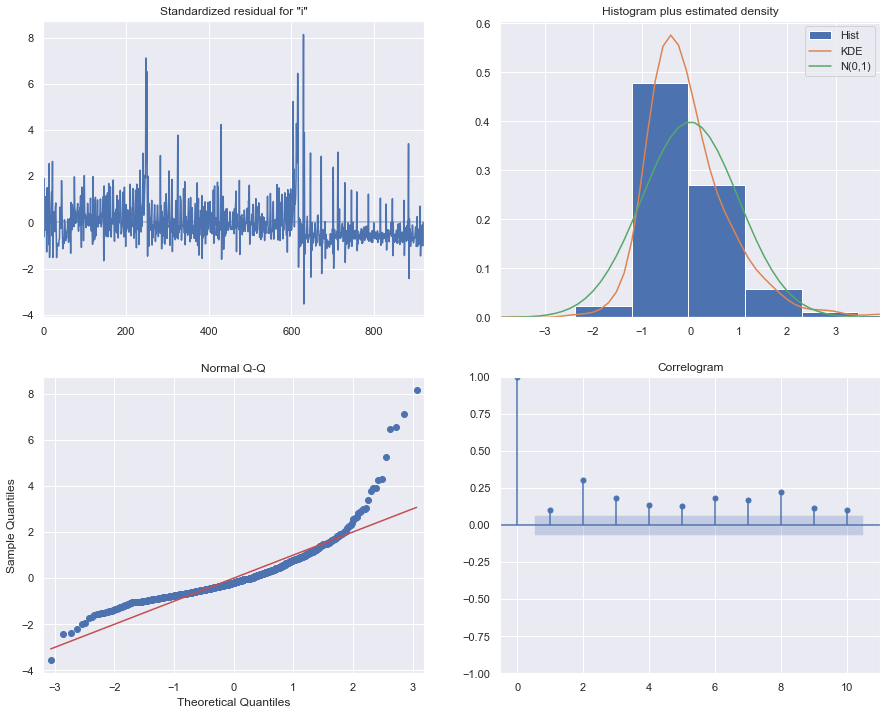

In [25]:
model = ARIMA(sales_20949['item_cnt_day'], order=(0,0,1))
model_fit = model.fit()
print(model_fit.summary())

model_fit.plot_diagnostics(figsize=(15,12))
plt.show()

- Make a 1 to 15 steps forecast, and plot the 95 percent confidence intervals.

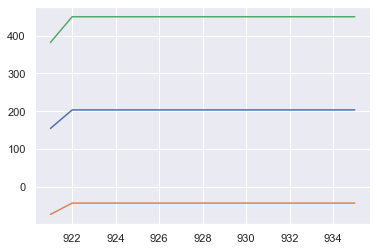

In [26]:
predictions = model_fit.get_forecast(steps=15)
plt.plot(predictions.predicted_mean)
plt.plot(predictions.conf_int(alpha=0.05))
plt.show()

-  Compare the goodness of fit of AR and MA models through AIC and BIC criteria.

In [27]:
model = ARIMA(sales_20949['item_cnt_day'], order=(1,0,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           item_cnt_day   No. Observations:                  921
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -5641.454
Date:                Mon, 12 Dec 2022   AIC                          11288.907
Time:                        15:30:16   BIC                          11303.384
Sample:                             0   HQIC                         11294.431
                                - 921                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        203.7372     10.325     19.732      0.000     183.500     223.974
ar.L1          0.5258      0.015     35.977      0.000       0.497       0.554
sigma2      1.225e+04    257.109     47.635      0.0

In [28]:
model = ARIMA(sales_20949['item_cnt_day'], order=(0,0,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           item_cnt_day   No. Observations:                  921
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -5684.366
Date:                Mon, 12 Dec 2022   AIC                          11374.732
Time:                        15:30:16   BIC                          11389.209
Sample:                             0   HQIC                         11380.256
                                - 921                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        203.7048      7.302     27.897      0.000     189.393     218.016
ma.L1          0.4180      0.017     24.909      0.000       0.385       0.451
sigma2      1.344e+04    300.563     44.708      0.0

-  What model performs the best according to you ?

The Auto Regressive model has the best AIC and BIC scores, albeit by a small margin.

- Make the ACF plots for various lags.

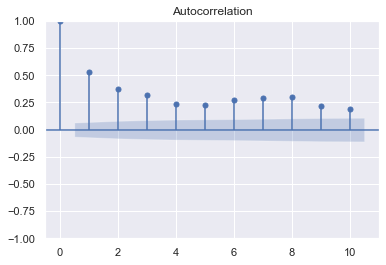

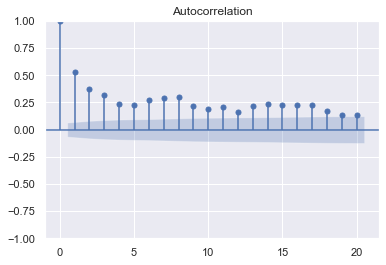

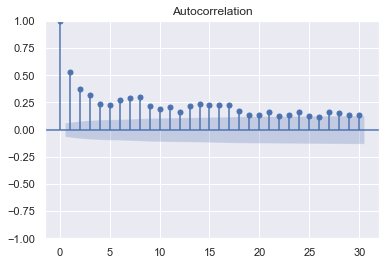

In [29]:
plot_acf(sales_20949['item_cnt_day'], lags=10).show()
plot_acf(sales_20949['item_cnt_day'], lags=20).show()
plot_acf(sales_20949['item_cnt_day'], lags=30).show()

- Use the residual analysis graphics of the Sarima function to check whether there are patterns in the residuals.

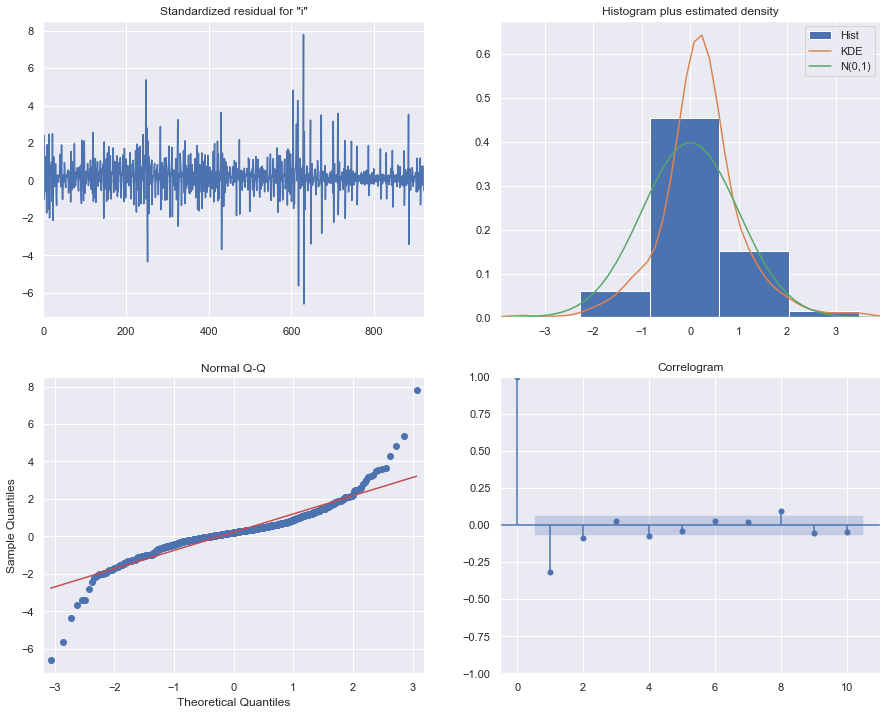

In [30]:
model = SARIMAX(sales_20949['item_cnt_day'], order=(1,0,0), seasonal_order=(1,0,0,12))
results = model.fit()
results.plot_diagnostics(figsize=(15,12))
plt.show()

-  Do you see any patterns in the residuals for the diverse models you have implemented ?

There are no visible patterns in the residuals.

- How should a Q-Q plot look like when the model is a good fit ?

The point scatter should look like a straight line.

- Fit various models (ARMA(1,1) - ARMA(2,1) - ARIMA(1,1,1) - ARIMA(1,1,0) to the Kaggle time series, and plot the t-table, check diagnostics.

                               SARIMAX Results                                
Dep. Variable:           item_cnt_day   No. Observations:                  921
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -5628.694
Date:                Mon, 12 Dec 2022   AIC                          11265.387
Time:                        15:30:17   BIC                          11284.689
Sample:                             0   HQIC                         11272.753
                                - 921                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        203.7369     13.658     14.917      0.000     176.967     230.507
ar.L1          0.7796      0.020     38.956      0.000       0.740       0.819
ma.L1         -0.3737      0.034    -10.978      0.0

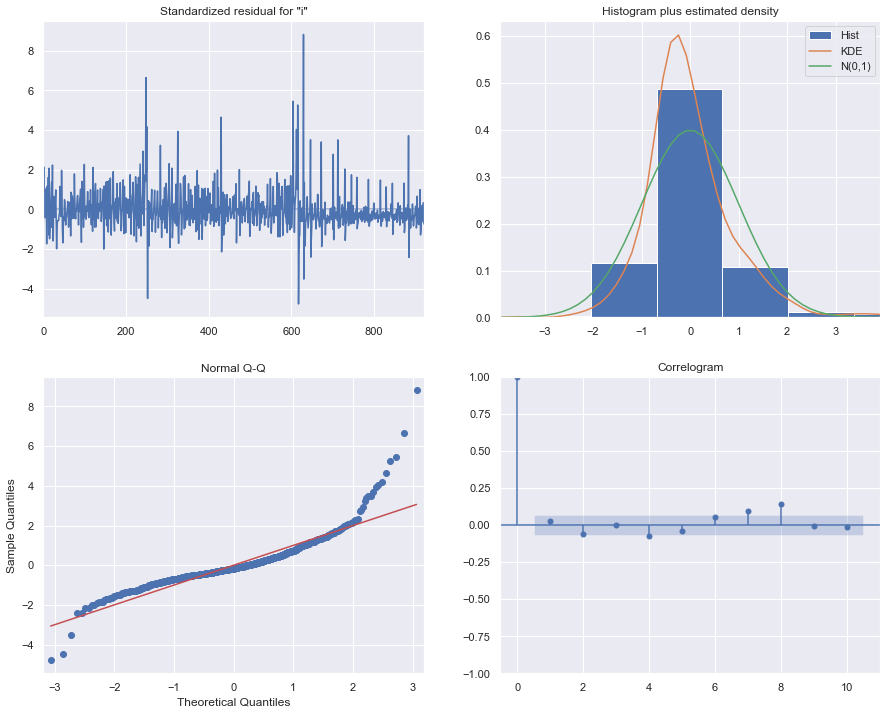

In [31]:
model = ARIMA(sales_20949['item_cnt_day'], order=(1,0,1))
model_fit = model.fit()
print(model_fit.summary())
model_fit.plot_diagnostics(figsize=(15,12))
plt.show()

                               SARIMAX Results                                
Dep. Variable:           item_cnt_day   No. Observations:                  921
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -5614.198
Date:                Mon, 12 Dec 2022   AIC                          11238.397
Time:                        15:30:18   BIC                          11262.524
Sample:                             0   HQIC                         11247.603
                                - 921                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        203.7033     27.436      7.425      0.000     149.929     257.477
ar.L1          1.3146      0.027     48.305      0.000       1.261       1.368
ar.L2         -0.3307      0.024    -13.908      0.0

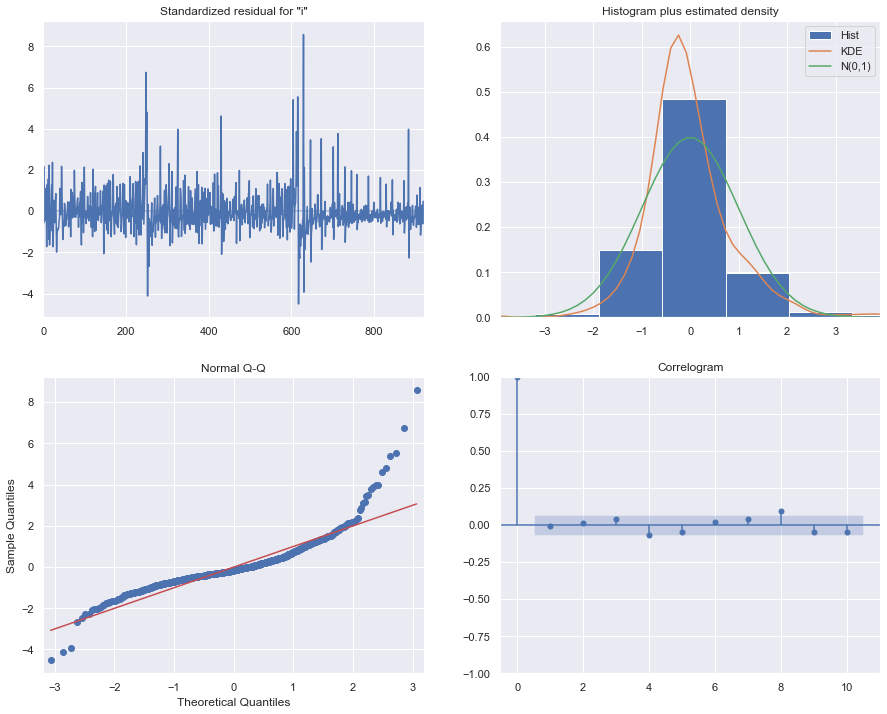

In [32]:
model = ARIMA(sales_20949['item_cnt_day'], order=(2,0,1))
model_fit = model.fit()
print(model_fit.summary())
model_fit.plot_diagnostics(figsize=(15,12))
plt.show()

                               SARIMAX Results                                
Dep. Variable:           item_cnt_day   No. Observations:                  921
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5612.298
Date:                Mon, 12 Dec 2022   AIC                          11230.596
Time:                        15:30:18   BIC                          11245.069
Sample:                             0   HQIC                         11236.119
                                - 921                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3675      0.021     17.657      0.000       0.327       0.408
ma.L1         -0.9406      0.007   -128.957      0.000      -0.955      -0.926
sigma2      1.163e+04    211.632     54.945      0.0

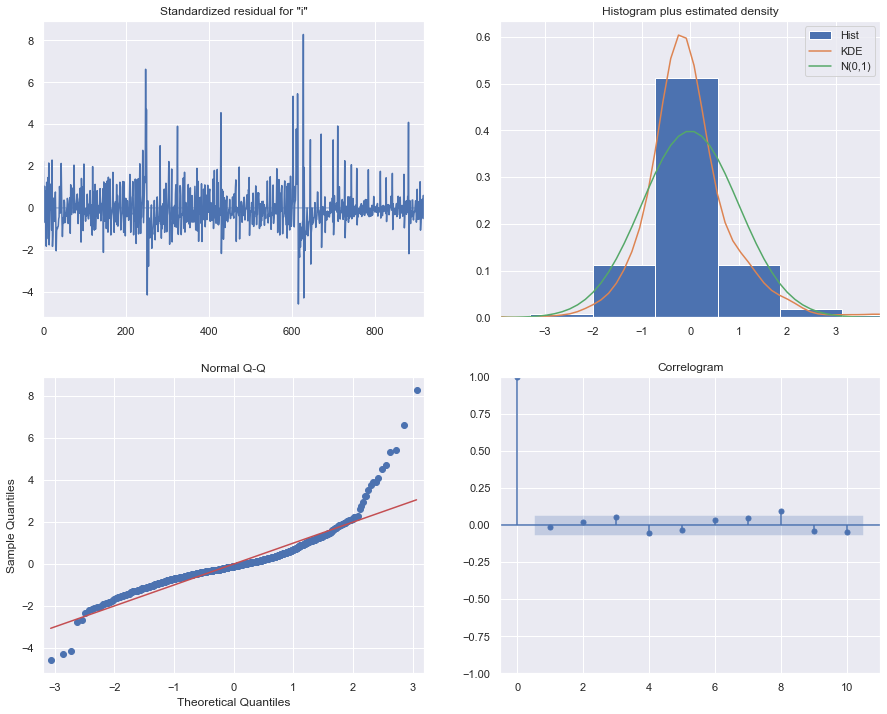

In [33]:
model = ARIMA(sales_20949['item_cnt_day'], order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())
model_fit.plot_diagnostics(figsize=(15,12))
plt.show()

                               SARIMAX Results                                
Dep. Variable:           item_cnt_day   No. Observations:                  921
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -5703.378
Date:                Mon, 12 Dec 2022   AIC                          11410.756
Time:                        15:30:19   BIC                          11420.405
Sample:                             0   HQIC                         11414.438
                                - 921                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3405      0.016    -20.951      0.000      -0.372      -0.309
sigma2      1.419e+04    256.747     55.286      0.000    1.37e+04    1.47e+04
Ljung-Box (L1) (Q):                   5.99   Jarque-

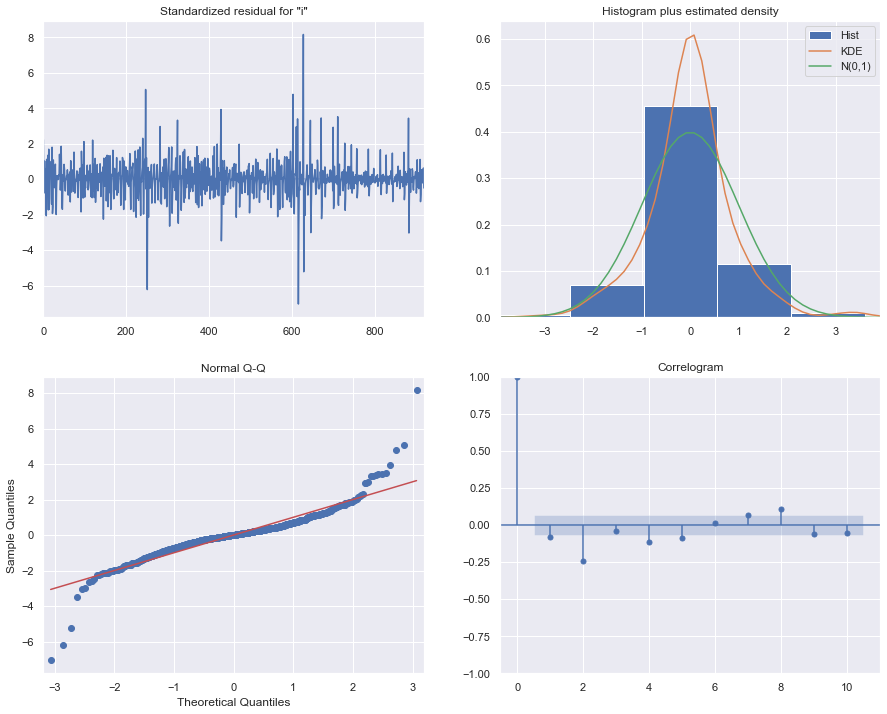

In [34]:
model = ARIMA(sales_20949['item_cnt_day'], order=(1,1,0))
model_fit = model.fit()
print(model_fit.summary())
model_fit.plot_diagnostics(figsize=(15,12))
plt.show()

- Fit a seasonal model to the Kaggle dataset. Fit ACF models with the relevant lags.

                                     SARIMAX Results                                      
Dep. Variable:                       item_cnt_day   No. Observations:                  921
Model:             SARIMAX(2, 1, 0)x(1, 0, 0, 12)   Log Likelihood               -5671.621
Date:                            Mon, 12 Dec 2022   AIC                          11351.242
Time:                                    15:30:20   BIC                          11370.540
Sample:                                         0   HQIC                         11358.606
                                            - 921                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4192      0.018    -23.770      0.000      -0.454      -0.385
ar.L2         -0.2427      0.020   

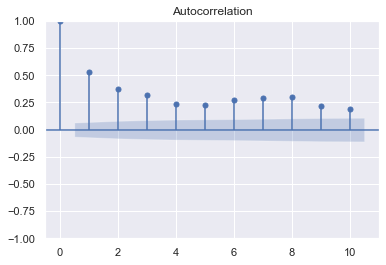

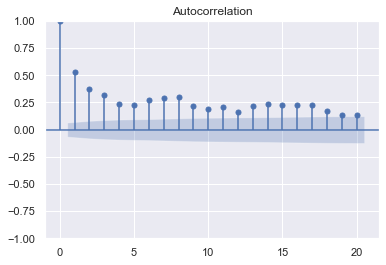

In [35]:
model = SARIMAX(sales_20949['item_cnt_day'], order=(2,1,0), seasonal_order=(1,0,0,12))
results = model.fit()
print(results.summary())

plot_acf(sales_20949['item_cnt_day'], lags=10).show()
plot_acf(sales_20949['item_cnt_day'], lags=20).show()

- What are the conceptual differences between an ARIMA and a SARIMA, from the mathematical point of view ?

An ARIMA model is a generalization of an ARMA model that can be used to describe non-stationary time series. A SARIMA model is an extension of the ARIMA model that explicitly supports univariate time series data with a seasonal component.

- Play with the parameters of the seasonnal component of the model (increase them), and see how forecasting is affected.

<AxesSubplot:>

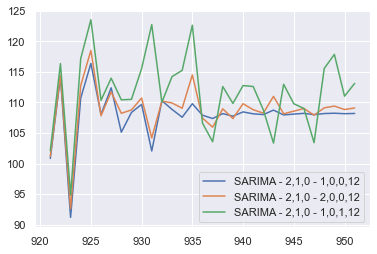

In [36]:
model = SARIMAX(sales_20949['item_cnt_day'], order=(2,1,0), seasonal_order=(1,0,0,12))
results = model.fit()
predictions = results.predict(start=len(sales_20949), end=len(sales_20949)+30, typ='levels').rename('SARIMA - 2,1,0 - 1,0,0,12')
predictions.plot(legend=True)

model = SARIMAX(sales_20949['item_cnt_day'], order=(2,1,0), seasonal_order=(2,0,0,12))
results = model.fit()
predictions = results.predict(start=len(sales_20949), end=len(sales_20949)+30, typ='levels').rename('SARIMA - 2,1,0 - 2,0,0,12')
predictions.plot(legend=True)

model = SARIMAX(sales_20949['item_cnt_day'], order=(2,1,0), seasonal_order=(1,0,1,12))
results = model.fit()
predictions = results.predict(start=len(sales_20949), end=len(sales_20949)+30, typ='levels').rename('SARIMA - 2,1,0 - 1,0,1,12')
predictions.plot(legend=True)

- Present a relevant sample of Ljung-Box tests, and explain how they can be used to assess your models.

In [37]:
model = ARIMA(sales_20949['item_cnt_day'], order=(1,0,0))
model_fit = model.fit()

print(acorr_ljungbox(model_fit.resid, lags=[10,20,30]))

model = ARIMA(sales_20949['item_cnt_day'], order=(0,0,1))
model_fit = model.fit()

print(acorr_ljungbox(model_fit.resid, lags=[10,20,30]))

model = ARIMA(sales_20949['item_cnt_day'], order=(1,0,1))
model_fit = model.fit()

print(acorr_ljungbox(model_fit.resid, lags=[10,20,30]))

       lb_stat     lb_pvalue
10   65.622702  3.080462e-10
20  114.721597  2.684261e-15
30  146.149211  3.214544e-17
       lb_stat     lb_pvalue
10  283.750892  4.207506e-55
20  435.174624  1.000523e-79
30  516.384379  5.241578e-90
      lb_stat     lb_pvalue
10  40.799275  1.224576e-05
20  68.005899  3.841309e-07
30  84.822794  3.912860e-07


The Ljung-Box test is used to determine if a time series is random noise. The null hypothesis of the test is that the time series is random noise. If the p-value is less than the significance level, then the null hypothesis can be rejected and it can be concluded that the time series is not random noise.

- Use your favourite model to forecast the time series on the available test datasets.

<AxesSubplot:>

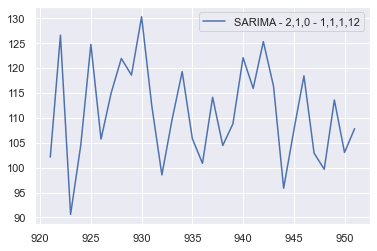

In [38]:
model = SARIMAX(sales_20949['item_cnt_day'], order=(2,1,0), seasonal_order=(1,1,1,12))
results = model.fit()
predictions = results.predict(start=len(sales_20949), end=len(sales_20949)+30, typ='levels').rename('SARIMA - 2,1,0 - 1,1,1,12')
predictions.plot(legend=True)

- Perform a naive forecast based on the forecast package, to predict the sales for the training datasets.

<AxesSubplot:>

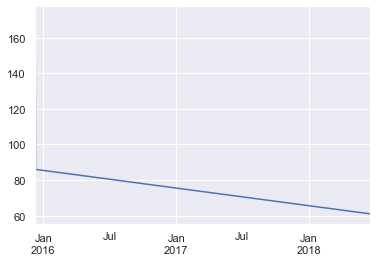

In [39]:
forecaster = NaiveForecaster(strategy="drift")
forecaster.fit(sales_20949.asfreq(freq='d')['item_cnt_day'])
y_pred = forecaster.predict(fh = np.arange(len(sales_20949) + 1))
y_pred.plot()

- Remind us to what correspond the two shades of blue in the confidence intervals.

The two shades of blue in the confidence intervals correspond to the 95% confidence interval.

- Use the accuracy command to compute the RMSE statistics of your favourite models.

In [40]:
model = SARIMAX(sales_20949['item_cnt_day'], order=(2,1,0), seasonal_order=(1,0,0,12))
results = model.fit()
predictions = results.predict(start=0, end=len(sales_20949)-1, typ='levels').rename('SARIMA - 2,1,0 - 1,0,0,12')

rmse = np.sqrt(mean_squared_error(sales_20949['item_cnt_day'], predictions))
print("RMSE: %f" % (rmse))

model = SARIMAX(sales_20949['item_cnt_day'], order=(2,1,0), seasonal_order=(2,0,0,12))
results = model.fit()
predictions = results.predict(start=0, end=len(sales_20949)-1, typ='levels').rename('SARIMA - 2,1,0 - 2,0,0,12')

rmse = np.sqrt(mean_squared_error(sales_20949['item_cnt_day'], predictions))
print("RMSE: %f" % (rmse))

model = SARIMAX(sales_20949['item_cnt_day'], order=(2,1,0), seasonal_order=(1,0,1,12))
results = model.fit()
predictions = results.predict(start=0, end=len(sales_20949)-1, typ='levels').rename('SARIMA - 2,1,0 - 1,0,1,12')

rmse = np.sqrt(mean_squared_error(sales_20949['item_cnt_day'], predictions))
print("RMSE: %f" % (rmse))

RMSE: 115.156342
RMSE: 115.117091
RMSE: 114.948204


- What does RMSE mean ? What is the difference with MAE ? Why is it usually preferred to MSE ?

RMSE is the square root of the mean of the squared errors. MAE is the mean of the absolute value of the errors. RMSE is preferred to MSE because it is in the same units as the response variable and is easier to interpret.

- Write a command that only returns the mean absolute percentage error.

In [41]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

- Compute cross-validated errors for up to a week ahead, with a naive forecast approach.

TODO

- Use Auto-ARIMA to fit a model to your data. How does Auto-ARIMA work ?

In [42]:
model = auto_arima(sales_20949['item_cnt_day'], start_p=0, start_q=0,
                            max_p=5, max_q=5, m=12,
                            start_P=0, seasonal=True,
                            d=1, D=1, trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=12089.570, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=11624.643, Time=0.23 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.51 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=11974.346, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=11530.393, Time=0.52 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.37 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.81 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=11642.528, Time=0.41 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=11489.200, Time=0.75 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=11589.749, Time=0.31 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=4.06 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.09 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=11477.527, Time=0.80 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AI

In [43]:
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  921
Model:             SARIMAX(5, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -5702.797
Date:                            Mon, 12 Dec 2022   AIC                          11421.594
Time:                                    15:31:14   BIC                          11460.084
Sample:                                         0   HQIC                         11436.291
                                            - 921                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4984      0.020    -25.445      0.000      -0.537      -0.460
ar.L2         -0.3508      0.024   

Auto-ARIMA automatically finds the optimal ARIMA model for a given time series. It does this by fitting many different ARIMA models and choosing the best one based on the lowest AIC or BIC value.

## Section 5

- Follow the prophet tutorial provided.

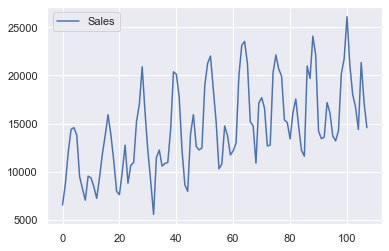

In [44]:
df = pd.read_csv('source/monthly-car-sales.csv')
df.plot()
plt.show()

In [45]:
df.columns = ['ds', 'y']
df['ds']= pd.to_datetime(df['ds'])
model = Prophet()
model.fit(df)

15:31:15 - cmdstanpy - INFO - Chain [1] start processing
15:31:15 - cmdstanpy - INFO - Chain [1] done processing


          ds          yhat    yhat_lower    yhat_upper
0 1968-01-01  14351.305350  12824.172266  16004.915050
1 1968-02-01  14916.307603  13344.319026  16453.702874
2 1968-03-01  20882.374712  19335.507299  22451.605430
3 1968-04-01  22899.345072  21320.275014  24475.496877
4 1968-05-01  24187.271687  22535.542979  25777.164423


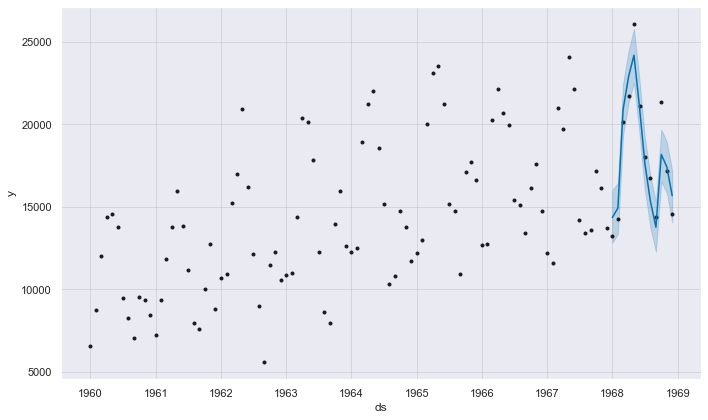

In [46]:
future = list()
for i in range(1, 13):
	date = '1968-%02d' % i
	future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])
forecast = model.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
model.plot(forecast)
plt.show()

          ds          yhat    yhat_lower    yhat_upper
0 1969-01-01  15413.180237  13828.955528  16777.689607
1 1969-02-01  16191.059024  14647.977981  17752.820628
2 1969-03-01  21389.177688  19871.725416  23014.482164
3 1969-04-01  23512.236773  21925.382408  25064.471670
4 1969-05-01  25018.217244  23530.687728  26650.425966


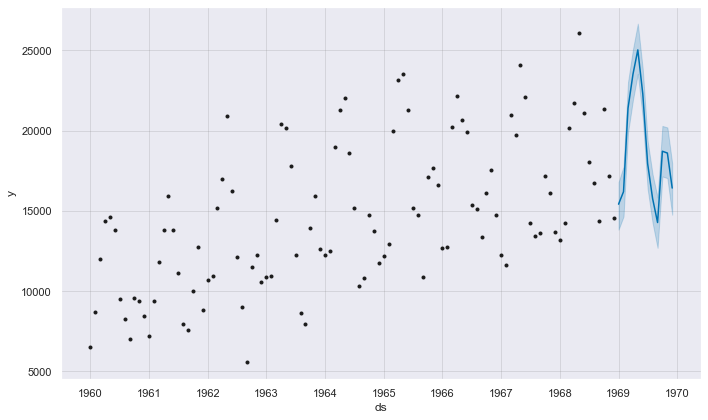

In [47]:
future = list()
for i in range(1, 13):
	date = '1969-%02d' % i
	future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])
forecast = model.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
model.plot(forecast)
plt.show()

15:31:16 - cmdstanpy - INFO - Chain [1] start processing


           ds      y
91 1967-08-01  13434
92 1967-09-01  13598
93 1967-10-01  17187
94 1967-11-01  16119
95 1967-12-01  13713


15:31:17 - cmdstanpy - INFO - Chain [1] done processing


MAE: 1336.813


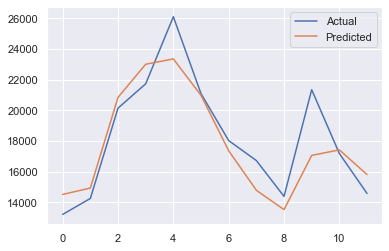

In [48]:
train = df.drop(df.index[-12:])
print(train.tail())
model = Prophet()
model.fit(train)
future = list()
for i in range(1, 13):
	date = '1968-%02d' % i
	future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds'] = pd.to_datetime(future['ds'])
forecast = model.predict(future)
y_true = df['y'][-12:].values
y_pred = forecast['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

- Make a Prophet forecast on the Kaggle dataset.

15:31:17 - cmdstanpy - INFO - Chain [1] start processing
15:31:17 - cmdstanpy - INFO - Chain [1] done processing


          ds        yhat  yhat_lower  yhat_upper
0 2013-01-05  433.014959  301.865958  569.289820
1 2013-01-06  373.629272  235.797000  506.774759
2 2013-01-07  300.110922  165.942254  427.781536
3 2013-01-08  295.821538  171.527471  430.103354
4 2013-01-09  272.134351  147.215283  411.975979


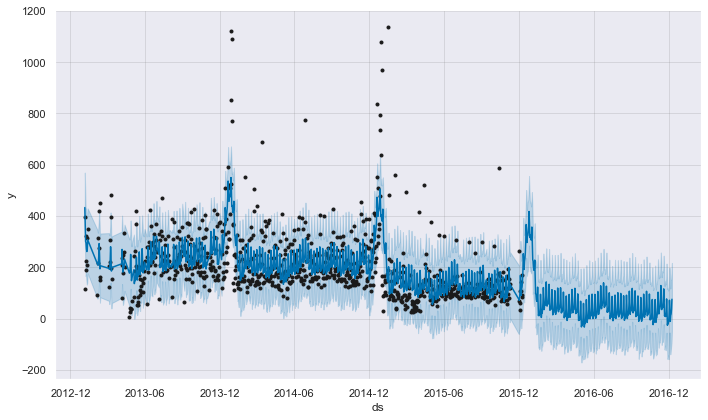

In [49]:
df = sales_20949.reset_index()
df = df[['date','item_cnt_day']]
df.columns = ['ds', 'y']
df['ds']= pd.to_datetime(df['ds'])
model = Prophet()
model.fit(df)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
model.plot(forecast)
plt.show()

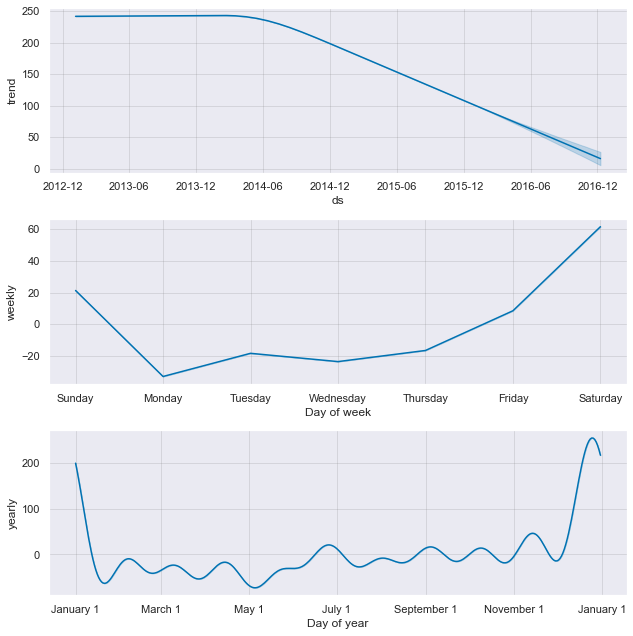

In [50]:
model.plot_components(forecast)
plt.show()

## Section 6

What is the point of having a cosine and sine part ? Where do these terms come from ? What are the differences with the real and imaginary part ? What is the added-value of having both the cos and the sin components, compared to a simple frequency spectrum like below ? What does such a frequency spectrum bring in terms of insight by contrast with an ACF ?

- Reproduce in Python an R Fourier tutorial.

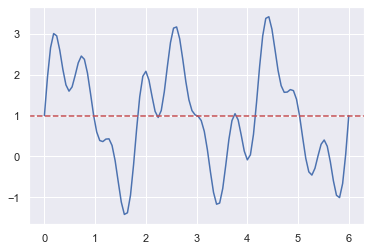

In [51]:
acq_freq = 100
time = 6
ts = np.linspace(0, time, 1 * acq_freq)
f_0 = 1/time

dc_component = 1
component_freqs = np.array([3,7,10])
component_delay = np.array([0,0,0])
component_strength = np.array([1.5,.5,.75])

def f(t,w):
    return dc_component + np.sum(component_strength * np.sin(component_freqs * w * t + component_delay))

def plot_fourier(fourier_series, f_0, ts):
    w = 2 * np.pi * f_0
    trajectory = np.array([fourier_series(t, w) for t in ts])
    plt.plot(ts, trajectory)
    plt.axhline(y=dc_component, color='r', linestyle='dashed')

plot_fourier(f, f_0, ts=ts)

In [52]:
w = 2 * np.pi * f_0
trajectory = np.array([f(t, w) for t in ts])

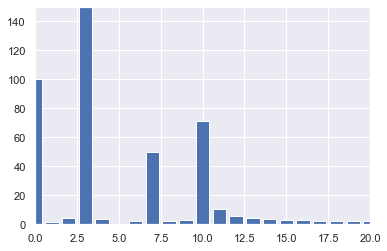

In [53]:
X_k = np.fft.fft(trajectory)

def plot_frequency_spectrum(X_k, xlim=[0, len(X_k)-1]):
    plot_data = np.array([[i, np.abs(X_k[i])] for i in range(len(X_k))])
    plot_data[1:, 1] = 2 * plot_data[1:, 1]
    plt.bar(plot_data[:, 0], plot_data[:, 1])
    plt.xlim(xlim)
    plt.ylim([0, np.max(plot_data[:, 1])])
    plt.show()

plot_frequency_spectrum(X_k, [0, 20])

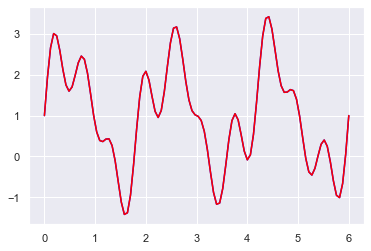

In [54]:
def get_trajectory(X_k, ts, acq_freq):
    N = len(ts)
    i = complex(0, 1)
    x_n = np.zeros(N)
    ks = np.arange(len(X_k))
    
    for n in range(N):
        x_n[n] = np.sum(X_k * np.exp(i*2*np.pi*ks*n/N)) / N

    return x_n * acq_freq

x_n = get_trajectory(X_k, ts, acq_freq) / acq_freq
plt.plot(ts, x_n, color='blue')
plt.plot(ts, trajectory, color='red')
plt.show()

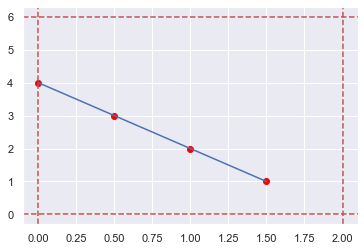

In [55]:
def plot_harmonic(X_k, i, ts, acq_freq, color='red'):
    X_k_h = np.zeros(len(X_k))
    X_k_h[i] = X_k[i]
    harmonic_trajectory = get_trajectory(X_k_h, ts, acq_freq)
    plt.plot(ts, harmonic_trajectory, color=color)

def plot_show(trajectory, time=1, harmonics=[-1], plot_freq=False):
    acq_freq = len(trajectory)/time
    ts = np.arange(0, time, 1/acq_freq)
    X_k = np.fft.fft(trajectory)
    x_n = get_trajectory(X_k, ts, acq_freq) / acq_freq

    if plot_freq:
        plot_frequency_spectrum(X_k)
    max_y = np.ceil(1.5 * np.max(np.abs(x_n)))

    if harmonics[0] == -1:
        min_y = np.floor(np.min(np.abs(x_n))) - 1
    else:
        min_y = np.ceil(-1.5 * np.max(np.abs(x_n)))
    
    plt.plot(ts, x_n)
    plt.axhline(y=min_y, color='r', linestyle='dashed')
    plt.axhline(y=max_y, color='r', linestyle='dashed')
    plt.axvline(x=0, color='r', linestyle='dashed')
    plt.axvline(x=time, color='r', linestyle='dashed')
    plt.scatter(ts, trajectory, color='red')
    
    color = ['red','blue','green','yellow','orange','purple','pink','brown','grey','black']

    if harmonics[0] > -1:
        for i in range(len(harmonics)):
            if harmonics[i] != 0:
                plot_harmonic(X_k, harmonics[i], ts, acq_freq, color=color[i])
            else :
                plt.plot(ts, np.zeros(len(ts)), color="red")

trajectory = np.arange(4, 0, -1)
plot_show(trajectory, time=2)

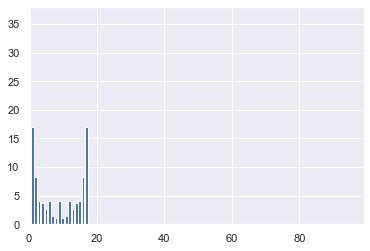

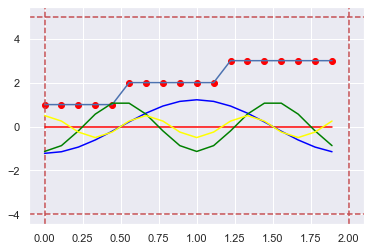

In [56]:
trajectory = np.concatenate((np.ones(5), np.ones(6)*2, np.ones(7)*3))
plot_show(trajectory, time=2, harmonics=[0,1,2,3], plot_freq=True)

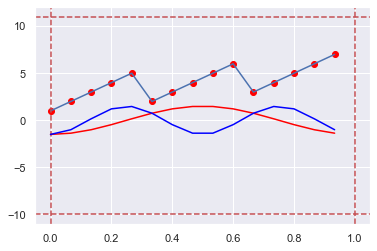

In [57]:
trajectory = np.concatenate((np.arange(1, 6), np.arange(2, 7), np.arange(3, 8)))
plot_show(trajectory, time=1, harmonics=[1, 2])

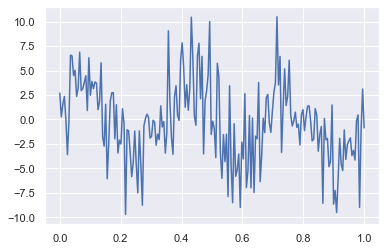

In [58]:
acq_freq = 200
time = 1
w = 2 * np.pi / time
ts = np.linspace(0, time, 1 * acq_freq)
trajectory = 3 * np.random.randn(acq_freq) + 3 * np.sin(3 * w * ts)
plt.plot(ts, trajectory)
plt.show()

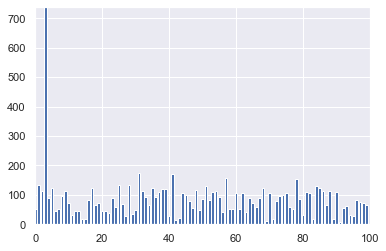

In [59]:
X_k = np.fft.fft(trajectory)
plot_frequency_spectrum(X_k, xlim=[0, acq_freq/2])

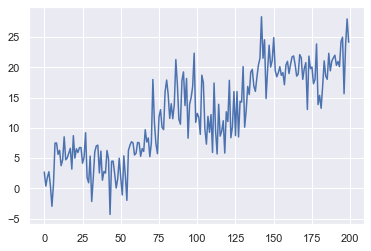

In [60]:
trajectory = trajectory + 25*ts
plt.plot(trajectory)
plt.show()

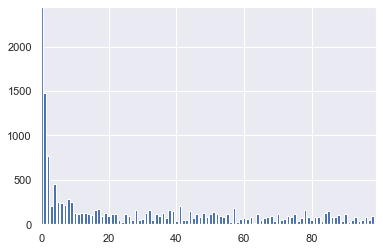

In [61]:
X_k = np.fft.fft(trajectory)
plot_frequency_spectrum(X_k)

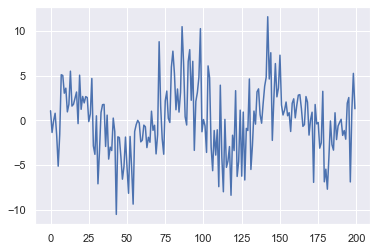

In [62]:
trend = smf.ols('trajectory ~ ts', data={'trajectory': trajectory, 'ts': ts}).fit()
detrended_trajectory = trend.resid
plt.plot(detrended_trajectory)
plt.show()

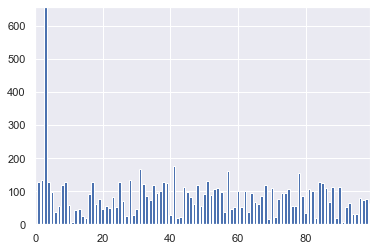

In [63]:
X_k = np.fft.fft(detrended_trajectory)
plot_frequency_spectrum(X_k)

## Section 7

Computing the matrix profile refers to the process of using a technique called matrix profile analysis to uncover patterns and similarities within large and complex datasets. This technique is particularly useful for time series data, which is data that is collected at regular intervals over time.

The matrix profile is a set of indices that are computed from a time series dataset, which can then be used to identify patterns and motifs within the data. The basic idea behind the matrix profile is to compare all possible sub-sequences of the time series data to each other, and to use this comparison to find the most similar pairs of sub-sequences.

The computation process starts with defining a distance metric between two sub-sequence. Euclidean distance is often used. Then a matrix profile is computed by comparing every subsequence in the time series to every other subsequence in the time series, and finding the shortest distance between them. This process is called a self-join of the time series and results in a matrix profile of the same length as the original time series where each element in the matrix profile is the distance between the closest match of the subsequence centered at that index, and the original subsequence.

Once the matrix profile is computed, it can be used to identify patterns and motifs within the time series data. For example, the matrix profile can be used to find the most similar pairs of sub-sequences within the time series data, which can indicate repeating patterns or motifs. Additionally, the matrix profile can be used to identify anomalies or outliers within the data, which can indicate unusual or unexpected events.

### Section 7.1

During the motif detection phase, there are several main parameters that can be adjusted to fine-tune the results of the matrix profile analysis. These include:

- The length of the sub-sequence: The length of the sub-sequence is the number of data points that are used to create each individual sub-sequence that is compared during the matrix profile calculation. Increasing the length of the sub-sequence will lead to fewer sub-sequences to compare, so it will increase the computational efficiency, but it also increases the risk of missing small patterns. Decreasing the length of the sub-sequence will increase the number of sub-sequences that need to be compared, so it will decrease the computational efficiency, but it also increases the chances of detecting small patterns.
- The distance metric: The distance metric is used to measure the similarity between sub-sequences. Euclidean distance is the most commonly used distance metric but other options like dynamic time warping (DTW) or others can be used. The choice of distance metric can have a significant impact on the results of the analysis, because it affects the way that the similarity between sub-sequences is measured. Changing the distance metric can lead to different patterns or motifs being detected depending on the nature of the data.
- The z-norm parameter: The z-norm parameter is used to normalize the time series data prior to the matrix profile calculation. It is based on the z-score and it's used to standardize the data across all subsequences. Changing the z-norm parameter can affect the matrix profile calculation and can make it more or less sensitive to variations in the data.
- The window size: This parameter sets the number of non-overlapping sub-sequences that will be considered at once in a sliding window fashion, which can be used to analyze the time series with segments. Changing the window size can affect the computational efficiency, and it can also affect the ability to detect motifs of different lengths.

Overall, playing with these parameters can be beneficial in order to get the most accurate and meaningful results, but it also requires some experience with the data and careful testing. Adjusting these parameters can have a significant impact on the results of the analysis, and it's important to keep in mind that the best settings will depend on the specific nature of the time series data being analyzed.

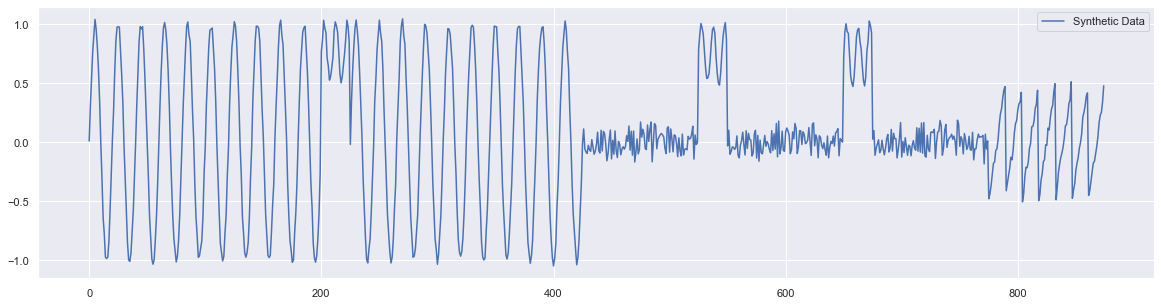

In [23]:
data = pd.read_csv('source/rawdata.csv')
pattern = data.data.values
fig, ax1 = plt.subplots(figsize=(20,5))
ax1.plot(np.arange(len(pattern)),pattern, label="Synthetic Data")
legend = ax1.legend(loc='upper right')

In [36]:
m = 32
mp = stomp(pattern,m)
cac = fluss(mp[1], m)

Text(0.5, 0, 'Sample')

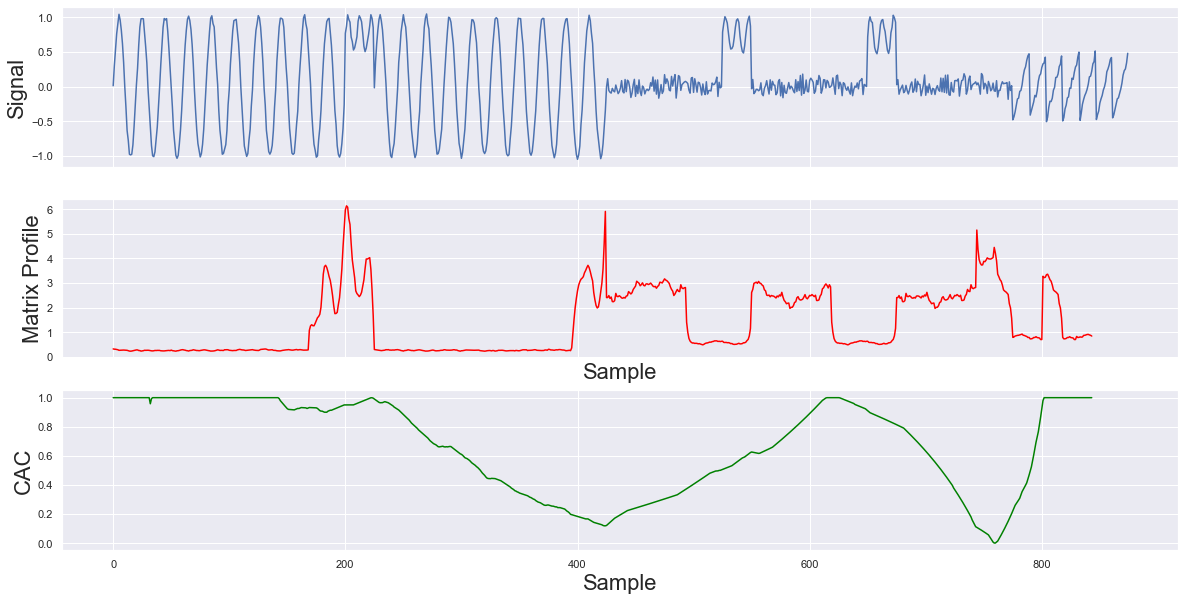

In [37]:
mp_adj = np.append(mp[0],np.zeros(m-1)+np.nan)

fig, (ax1, ax2, ax3) = plt.subplots(3,1,sharex=True,figsize=(20,10))
ax1.plot(np.arange(len(pattern)),pattern, label="Synthetic Data")
ax1.set_ylabel('Signal', size=22)

ax2.plot(np.arange(len(mp_adj)),mp_adj, label="Matrix Profile", color='red')
ax2.set_ylabel('Matrix Profile', size=22)
ax2.set_xlabel('Sample', size=22)

ax3.plot(np.arange(len(cac)),cac, label="CAC", color='green')
ax3.set_ylabel('CAC', size=22)
ax3.set_xlabel('Sample', size=22)

In [41]:
m = 32
mp = stomp(pattern,m)

In [38]:
def plot_motifs(mtfs, labels, ax):

    colori = 0
    colors = 'rgbcm'
    for ms,l in zip(mtfs,labels):
        c =colors[colori % len(colors)]
        starts = list(ms)
        ends = [min(s + m,len(pattern)-1) for s in starts]
        ax.plot(starts, pattern[starts],  c +'o',  label=l)
        ax.plot(ends, pattern[ends],  c +'o', markerfacecolor='none')
        for nn in ms:
            ax.plot(range(nn,nn+m),pattern[nn:nn+m], c , linewidth=2)
        colori += 1

    ax.plot(pattern, 'k', linewidth=1, label="data")
    ax.legend()

In [42]:
mtfs,motif_d  = motifs(pattern, mp, max_motifs=10)

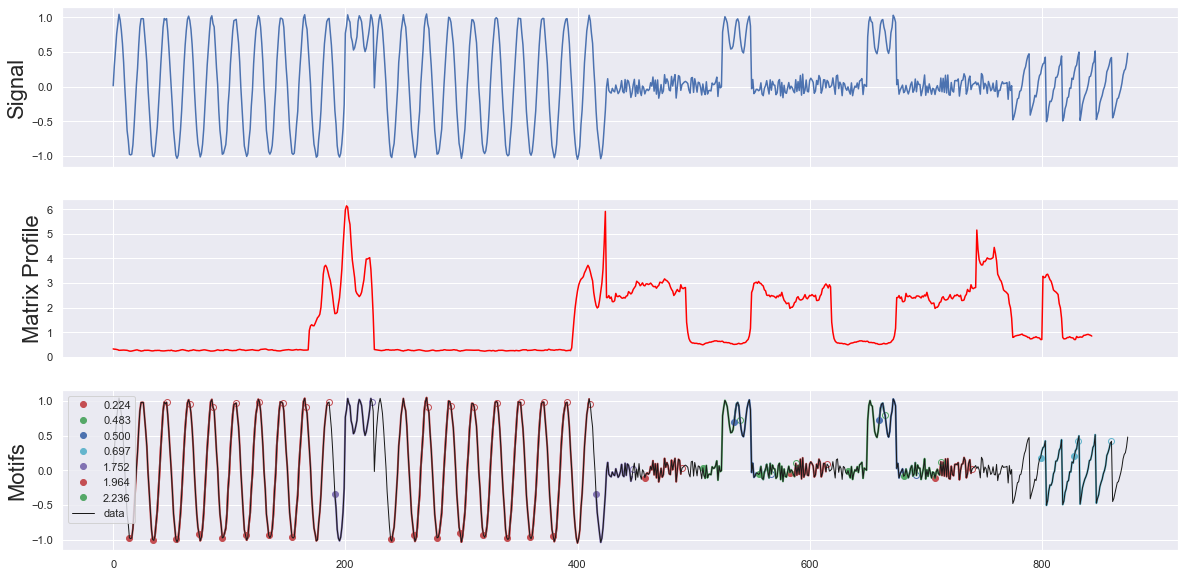

In [44]:
mp_adj = np.append(mp[0],np.zeros(m-1)+np.nan)

fig, (ax1, ax2, ax3) = plt.subplots(3,1,sharex=True,figsize=(20,10))
ax1.plot(np.arange(len(pattern)),pattern, label="Synthetic Data")
ax1.set_ylabel('Signal', size=22)

ax2.plot(np.arange(len(mp_adj)),mp_adj, label="Matrix Profile", color='red')
ax2.set_ylabel('Matrix Profile', size=22)

plot_motifs(mtfs, [f"{md:.3f}" for md in motif_d], ax3)
ax3.set_ylabel('Motifs', size=22)
plt.show()

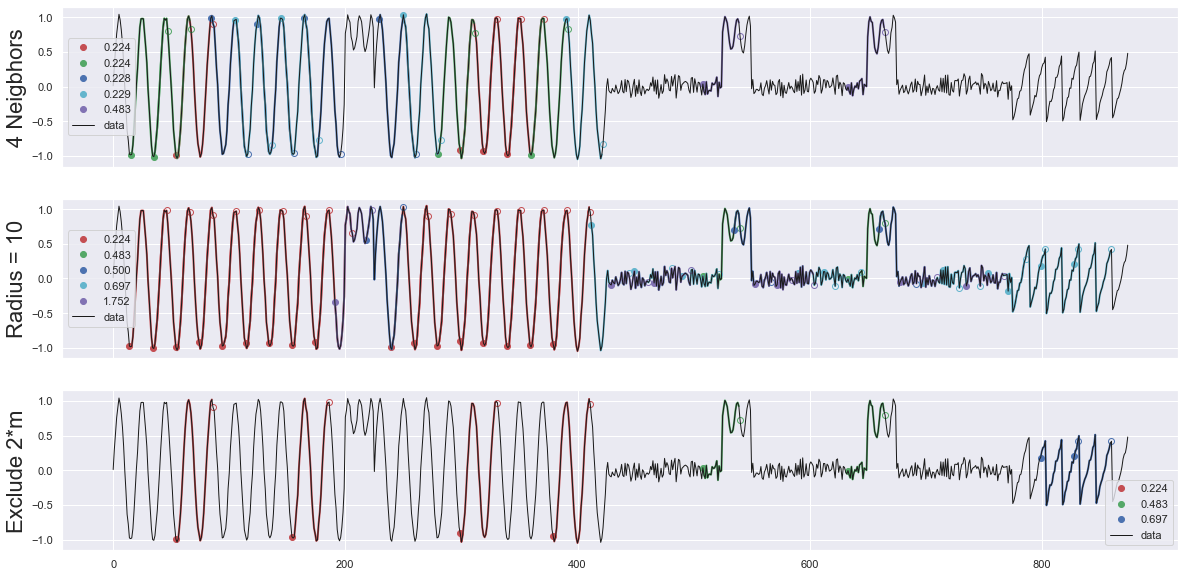

In [46]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,sharex=True,figsize=(20,10))

mtfs ,motif_d  = motifs(pattern, mp, max_motifs=5, n_neighbors=4)
plot_motifs(mtfs, [f"{md:.3f}" for md in motif_d], ax1)
ax1.set_ylabel('4 Neigbhors', size=22)

mtfs ,motif_d  = motifs(pattern, mp, max_motifs=5, radius=10)
plot_motifs(mtfs, [f"{md:.3f}" for md in motif_d], ax2)
ax2.set_ylabel('Radius = 10', size=22)

mtfs ,motif_d  = motifs(pattern, mp, max_motifs=5, ex_zone=2*m)
plot_motifs(mtfs, [f"{md:.3f}" for md in motif_d], ax3)
ax3.set_ylabel('Exclude 2*m', size=22)
plt.show()

Imagine applications of motif detection in 5 different activity sectors.

- Healthcare: Motif detection can be used in genomics to identify specific DNA sequences that are overrepresented in a given dataset. This can help researchers understand how different genetic variations contribute to disease risk or drug response. For example, a study may use motif detection to identify the presence of specific transcription factor binding sites in genes associated with a particular cancer, which could provide insight into how the disease develops and how it might be treated.
- Finance: Motif detection can be used in financial analysis to identify patterns in stock market data. For example, it can be used to find repeating sequences of price movements that are associated with a particular stock or market index. This information can be used by traders to make informed investment decisions.
- Cybersecurity: Motif detection can be used to identify patterns of activity that indicate malicious behavior on a network. For example, it can be used to identify specific sequences of network packets that are associated with a particular type of attack, such as a denial-of-service attack or a phishing campaign. This can help network administrators and cybersecurity experts respond to these threats more effectively.
- Agriculture: Motif detection can be used in crop breeding to identify specific genetic sequences that are associated with desirable traits such as disease resistance or high yield. This can help breeders develop new crop varieties that are more resilient and productive.
- Natural Language Processing: In NLP, motif detection can be used for text summarization by identifying common phrases or concepts that are repeatedly mentioned in a given text. It can also be used for sentiment analysis by identifying patterns of words that are associated with positive or negative emotions. This can be helpful for automating feedback analysis, reviews analysis and customer service ticket categorization.

### Section 7.2

In [2]:
taxi = pd.read_csv('source/nyc_taxi.csv', parse_dates=['timestamp'])

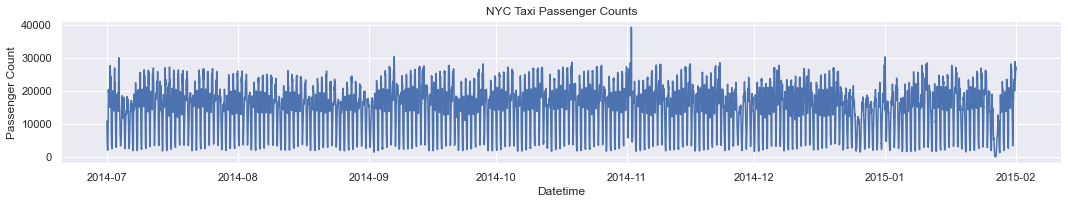

In [3]:
plt.figure(figsize=(15,3))
plt.plot(taxi['timestamp'], taxi['value'])
plt.title('NYC Taxi Passenger Counts')
plt.ylabel('Passenger Count')
plt.xlabel('Datetime')
plt.tight_layout()
plt.show()

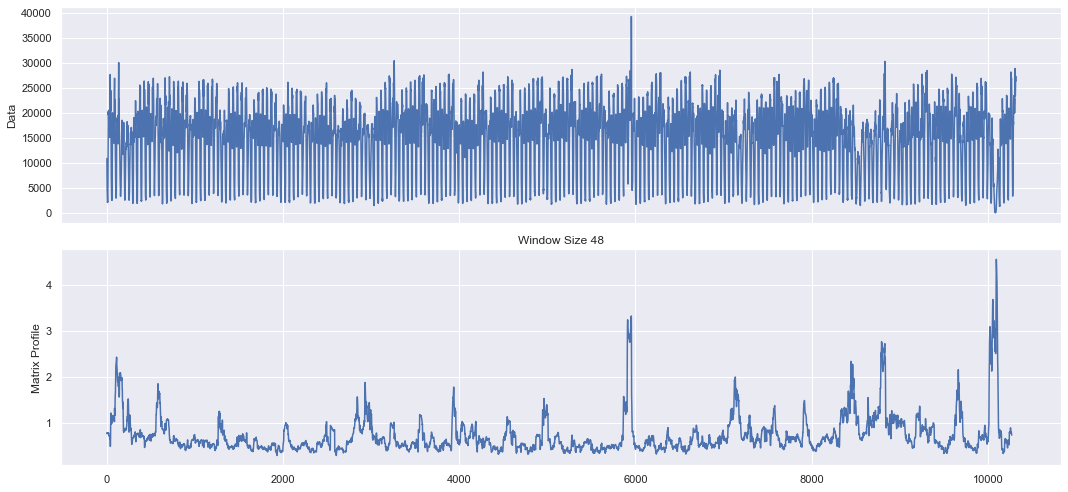

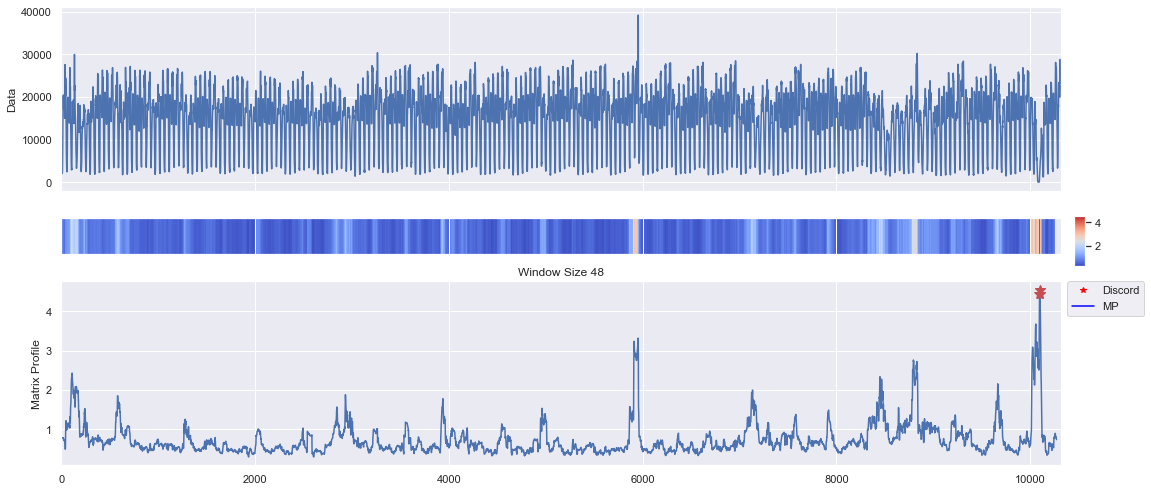

In [6]:
window_size = 48
profile = mp.compute(taxi['value'].to_numpy(), windows=window_size)
profile = mp.discover.discords(profile, k=5)
mp.visualize(profile)
plt.show()

In [8]:
for dt in taxi['timestamp'][profile['discords']]:
    print(dt)

2015-01-27 09:00:00
2015-01-27 08:30:00
2015-01-27 08:00:00
2015-01-27 09:30:00
2015-01-27 10:00:00


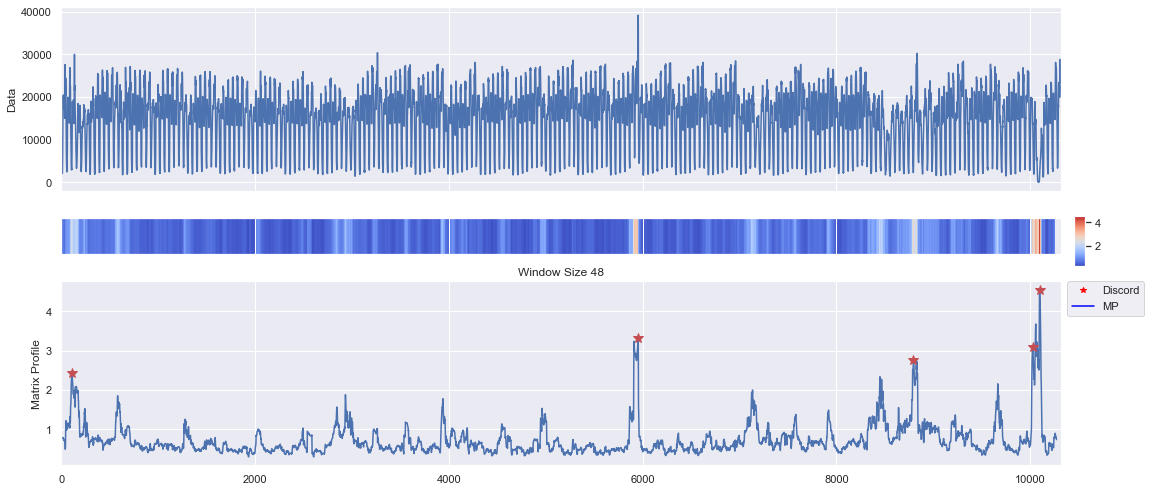

In [10]:
profile = mp.discover.discords(profile, exclusion_zone=window_size, k=5)
plot_discords_mp(profile)
plt.show()

In [11]:
for dt in taxi['timestamp'][profile['discords']]:
    print(dt)

2015-01-27 09:00:00
2014-11-02 00:30:00
2015-01-25 20:30:00
2014-12-31 05:30:00
2014-07-03 07:00:00


### Section 7.3

In [12]:
tssb = load_time_series_segmentation_datasets()

In [13]:
for _, (ts_name, window_size, cps, ts) in tssb.iterrows():
    found_cps = ClaSPSegmentation(window_size, n_cps=len(cps)).fit_predict(ts)
    score = relative_change_point_distance(cps, found_cps, ts.shape[0])
    print(f"Time Series: {ts_name}: True Change Points: {cps}, Found Change Points: {found_cps.tolist()}, Score: {score}")

Time Series: Adiac: True Change Points: [ 572 1012 1232], Found Change Points: [565, 1015, 1235], Score: 0.003078
Time Series: ArrowHead: True Change Points: [753], Found Change Points: [750], Score: 0.001992
Time Series: Beef: True Change Points: [705], Found Change Points: [686], Score: 0.013475
Time Series: BeetleFly: True Change Points: [1280], Found Change Points: [1280], Score: 0.0
Time Series: BirdChicken: True Change Points: [1280], Found Change Points: [1276], Score: 0.001562
Time Series: Car: True Change Points: [ 577 1154 1550], Found Change Points: [1146, 568, 1512], Score: 0.008476
Time Series: CBF: True Change Points: [384 704], Found Change Points: [390, 697], Score: 0.006771
Time Series: ChlorineConcentration: True Change Points: [2365], Found Change Points: [2365], Score: 0.0
Time Series: CinCECGTorso: True Change Points: [2663 5121], Found Change Points: [5148, 2651], Score: 0.00272
Time Series: Coffee: True Change Points: [500], Found Change Points: [497], Score: 0.0

In [15]:
tssb = load_time_series_segmentation_datasets(names=["ArrowHead", "InlineSkate", "Plane"])

Time Series: ArrowHead: True Change Points: [753], Found Change Points: [750], Score: 0.001992


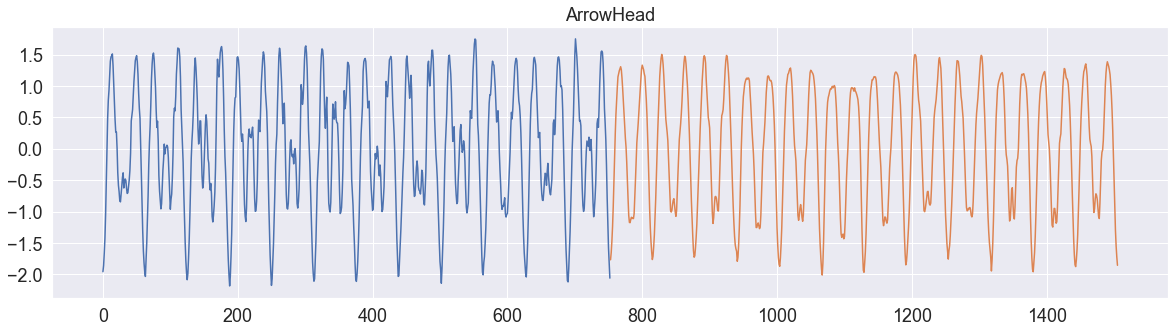

Time Series: InlineSkate: True Change Points: [1058 2704], Found Change Points: [978, 3089], Score: 0.048227


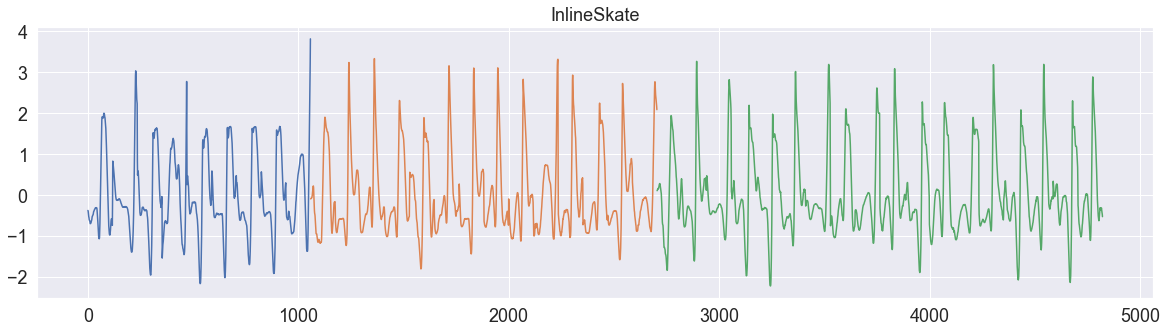

Time Series: Plane: True Change Points: [ 540 1044 1368 1944 2412 3060], Found Change Points: [2412, 3060, 1371, 1942, 1050, 535], Score: 0.000705


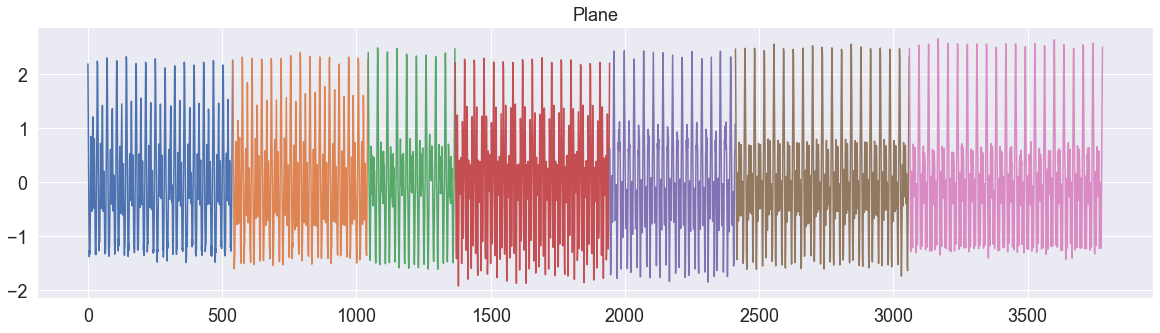

In [17]:
for _, (ts_name, window_size, cps, ts) in tssb.iterrows():
    found_cps = ClaSPSegmentation(window_size, n_cps=len(cps)).fit_predict(ts)
    score = relative_change_point_distance(cps, found_cps, ts.shape[0])
    print(f"Time Series: {ts_name}: True Change Points: {cps}, Found Change Points: {found_cps.tolist()}, Score: {score}")
    fig, ax = visualize_time_series(ts, ts_name, cps)
    plt.show()

Time series segmentation is the process of dividing a time series into multiple segments or intervals, each with its own unique characteristics. Some of the main applications of time series segmentation include:

- Anomaly detection: By segmenting a time series into smaller intervals, it becomes easier to identify unusual or abnormal patterns that deviate from the norm. This is especially useful in fields such as finance and manufacturing, where unusual patterns can indicate potential fraud or equipment failure.
- Predictive modeling: By identifying patterns in different segments of a time series, it becomes possible to create more accurate models for forecasting future values. This can be particularly useful in fields such as supply chain management, where the ability to predict demand can help businesses plan more effectively.
- Maintenance and repair: Time series segmentation can be used to identify patterns of wear and tear in equipment over time, allowing for proactive maintenance and repair to be scheduled before a failure occurs.
- Sentiment Analysis: The time series of text data can be segmented to understand the evolution of topics, opinion, and emotions.
- Quality Control: in manufacturing and process industries, time series segmentation allows for early detection of fluctuations in the quality of the production process.

## Section 8

In [3]:
df = pd.read_csv("source/AirPassengers.csv", delimiter=",")
series = TimeSeries.from_dataframe(df, "Month", "#Passengers")
train, val = series[:-36], series[-36:]

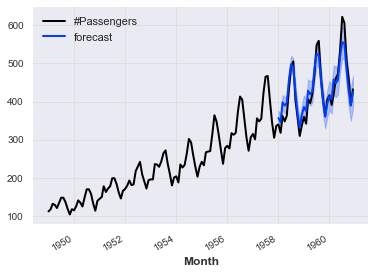

In [16]:
model = ExponentialSmoothing()
model.fit(train)
prediction = model.predict(len(val), num_samples=1000)
series.plot()
prediction.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()
plt.show()

In [33]:
train, val = series.split_after(pd.Timestamp("19590101"))

transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

year_series = datetime_attribute_timeseries(
    pd.date_range(start=series.start_time(), freq=series.freq_str, periods=1000),
    attribute="year",
    one_hot=False,
)
year_series = Scaler().fit_transform(year_series)
month_series = datetime_attribute_timeseries(
    year_series, attribute="month", one_hot=True
)
covariates = year_series.stack(month_series)
cov_train, cov_val = covariates.split_after(pd.Timestamp("19590101"))

In [ ]:
my_model = RNNModel(
    model="LSTM",
    hidden_dim=20,
    dropout=0,
    batch_size=16,
    n_epochs=300,
    optimizer_kwargs={"lr": 1e-3},
    model_name="Air_RNN",
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    input_chunk_length=14,
    force_reset=True,
    save_checkpoints=True,
)

In [ ]:
my_model.fit(
    train_transformed,
    future_covariates=covariates,
    val_series=val_transformed,
    val_future_covariates=covariates,
    verbose=True,
)

In [ ]:
def eval_model(model):
    pred_series = model.predict(n=26, future_covariates=covariates)
    plt.figure(figsize=(8, 5))
    series_transformed.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title("MAPE: {:.2f}%".format(mape(pred_series, val_transformed)))
    plt.legend()


eval_model(my_model)

## Section 9

In [54]:
signal, sr = librosa.load('source/fire.wav')

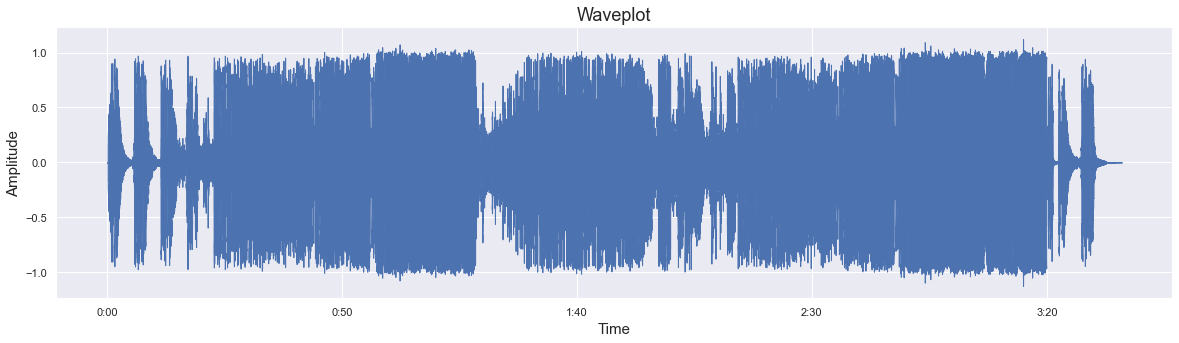

In [55]:
plt.figure(figsize=(20, 5))
librosa.display.waveshow(signal, sr=sr)
plt.title('Waveplot', fontdict=dict(size=18))
plt.xlabel('Time', fontdict=dict(size=15))
plt.ylabel('Amplitude', fontdict=dict(size=15))
plt.show()

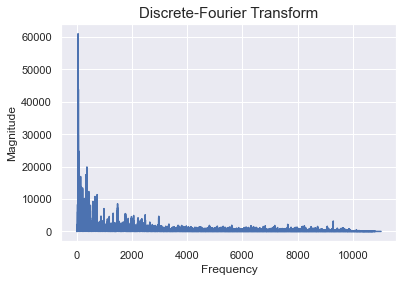

In [56]:
fast_fourier_transf = np.fft.fft(signal)

magnitude = np.abs(fast_fourier_transf)

frequency = np.linspace(0, sr, len(magnitude))

left_mag = magnitude[:int(len(magnitude)/2)]
left_freq = frequency[:int(len(frequency)/2)]

plt.plot(left_freq, left_mag)
plt.title('Discrete-Fourier Transform', fontdict=dict(size=15))
plt.xlabel('Frequency', fontdict=dict(size=12))
plt.ylabel('Magnitude', fontdict=dict(size=12))
plt.show()

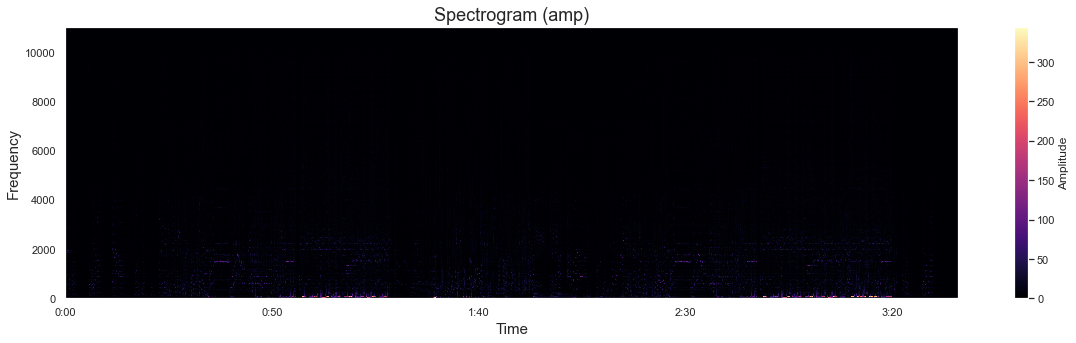

In [57]:
n_fft = 2048

hop_length = 512

audio_stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)

spectrogram = np.abs(audio_stft)

plt.figure(figsize=(20, 5))

librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='hz', hop_length=hop_length)
plt.colorbar(label='Amplitude')

plt.title('Spectrogram (amp)', fontdict=dict(size=18))
plt.xlabel('Time', fontdict=dict(size=15))
plt.ylabel('Frequency', fontdict=dict(size=15))
plt.show()

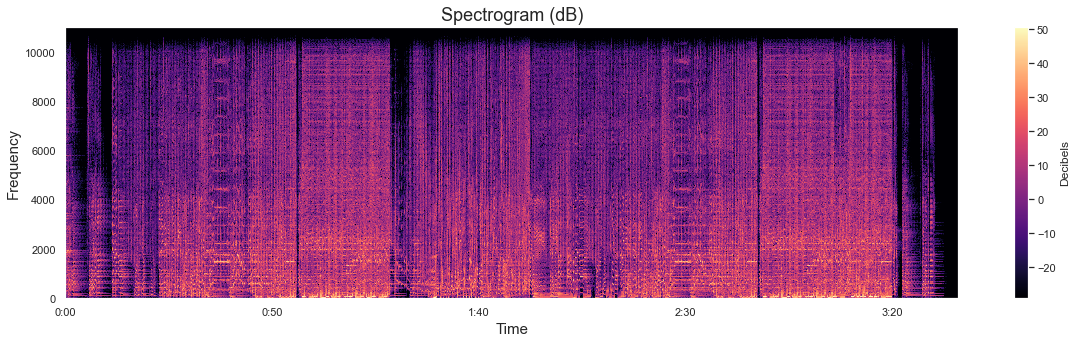

In [58]:
audio_stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)

spectrogram = np.abs(audio_stft)

log_spectro = librosa.amplitude_to_db(spectrogram)

plt.figure(figsize=(20, 5))

librosa.display.specshow(log_spectro, sr=sr, x_axis='time', y_axis='hz', hop_length=hop_length, cmap='magma')

plt.colorbar(label='Decibels')
plt.title('Spectrogram (dB)', fontdict=dict(size=18))
plt.xlabel('Time', fontdict=dict(size=15))
plt.ylabel('Frequency', fontdict=dict(size=15))
plt.show()

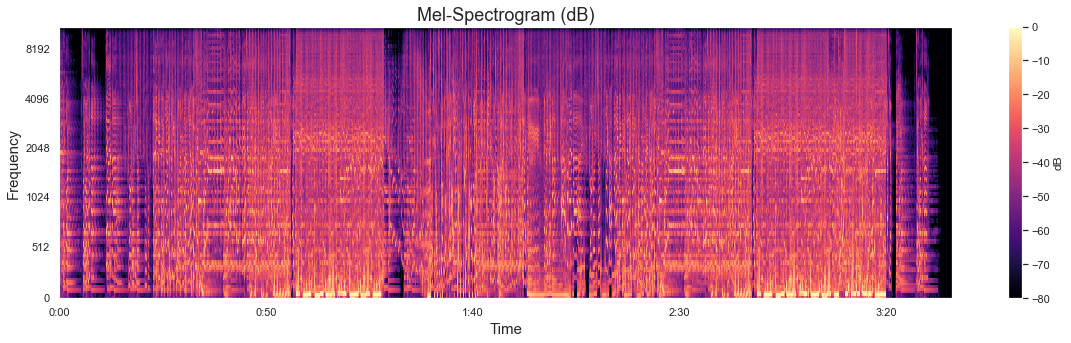

In [61]:
mel_signal = librosa.feature.melspectrogram(y=signal, sr=sr, hop_length=hop_length, n_fft=n_fft)
spectrogram = np.abs(mel_signal)
power_to_db = librosa.power_to_db(spectrogram, ref=np.max)
plt.figure(figsize=(20, 5))
librosa.display.specshow(power_to_db, sr=sr, x_axis='time', y_axis='mel', cmap='magma', hop_length=hop_length)
plt.colorbar(label='dB')
plt.title('Mel-Spectrogram (dB)', fontdict=dict(size=18))
plt.xlabel('Time', fontdict=dict(size=15))
plt.ylabel('Frequency', fontdict=dict(size=15))
plt.show()